In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from datasets.utils import get_split_indecies
from tools.utils import set_seed
import numpy as np
import h5py

set_seed(1234)

2023-08-13 13:36:51.369240: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-13 13:36:51.525489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 13:36:52.114738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
reload_module("datasets.fabric")
reload_module("datasets.radio_ml_2018")
from datasets.fabric import make_sigmod_ds, DatasetName
ds = make_sigmod_ds(DatasetName.RADIOML_2018)
radioml2018_data_path = cur_dir + "/data/radioml_2018/GOLD_XYZ_OSC.0001_1024.hdf5"
radioml2018_classes_path = cur_dir + "/data/radioml_2018/classes.txt"
ds.load((radioml2018_data_path, radioml2018_classes_path))
split_indecies = get_split_indecies(len(ds.get_snrs()), 0.8, 0.1)

train_model = False


In [3]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName
from evaluation.results_serialization import load_results

model_name = "cnn_1d_v012_small_radio_ml18"

if train_model:
    cnn_1d_v012_3_configuration = Convolution01xConfiguration(
        input_shape=(1024, 2),
        n_classes=len(ds.get_modulations()),
        output_channels=[32, 48, 64, 96],
        kernel_sizes=[8, 8, 8, 8],
        paddings=["same", "same", "same", "same",],
        max_pool_sizes=[2, 2, 2, 2],
        max_pool_strides=[2, 2, 2, 2],
        avg_size=32,
        dense_sizes=[96],
    )

    model_configuration = cnn_1d_v012_3_configuration

    model = make_sigmod_model(ModelName.CNN_1D_V012, model_configuration)

    model.summary()
else:
    results = load_results(model_name + "_results/", load_model=True)
    model = results["model"]

2023-08-13 13:36:56.095694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-13 13:36:56.180432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-13 13:36:56.180644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
import tensorflow as tf

N_EPOCHS = 25
BATCH_SIZE = 256
# BATCH_SIZE = 1024

if train_model:
    train_gen = ds.to_keras_generator(split_indecies.train, BATCH_SIZE)
    val_gen = ds.to_keras_generator(split_indecies.val, BATCH_SIZE)


    def step_decay(epoch):
        # lrate = 0.001
        # factor = epoch // 8
        # lrate /= 10**factor
        return 0.001
        lrate = 0.001
        if epoch >= 16:
            lrate /= 10
        if epoch >= 24:
            lrate /= 4
        if epoch >= 32:
            lrate /= 4
        if epoch >= 40:
            lrate /= 2
        # factor = epoch // 8
        # lrate /= 10**factor
        return lrate


    lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    # N_EPOCHS = 16


    h = model.fit_generator(
        generator=train_gen,
        validation_data=val_gen,
        
        use_multiprocessing=True,
        workers=12,
        
        epochs=N_EPOCHS,
        callbacks=[lrate]
)


# val_gen = 

In [5]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train, plot_snr_to_acc
if train_model:
    plot_train(h.history)

2023-08-11 22:41:21.260333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-11 22:41:22.898040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


  1/998 [..............................] - ETA: 38:50

2023-08-11 22:41:23.585076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


998/998 [==============================] - 115s 113ms/step
Preds shape: (255488, 24)
Overall test accuracy: {'Overall': 0.5924309556613226}
32PSK test accuracy: 0.7730152814014163
16APSK test accuracy: 0.6700512342803913
32QAM test accuracy: 0.6798366416563776
FM test accuracy: 0.7407511210762332
GMSK test accuracy: 0.6306083650190114
32APSK test accuracy: 0.5834122325317175
OQPSK test accuracy: 0.5687091580642106
8ASK test accuracy: 0.5247219366295915
BPSK test accuracy: 0.6107395195478097
8PSK test accuracy: 0.6448563137695404
AM-SSB-SC test accuracy: 0.4626067373557286
4ASK test accuracy: 0.41305361305361304
16PSK test accuracy: 0.5646475049152702
64APSK test accuracy: 0.5108675459780792
128QAM test accuracy: 0.3998485422188565
128APSK test accuracy: 0.3958999435772052
AM-DSB-SC test accuracy: 0.35446927374301673
AM-SSB-WC test accuracy: 0.6377915726109857
64QAM test accuracy: 0.48841153193894854
QPSK test accuracy: 0.7328236980410894
256QAM test accuracy: 0.6095948625932571
AM-DSB-

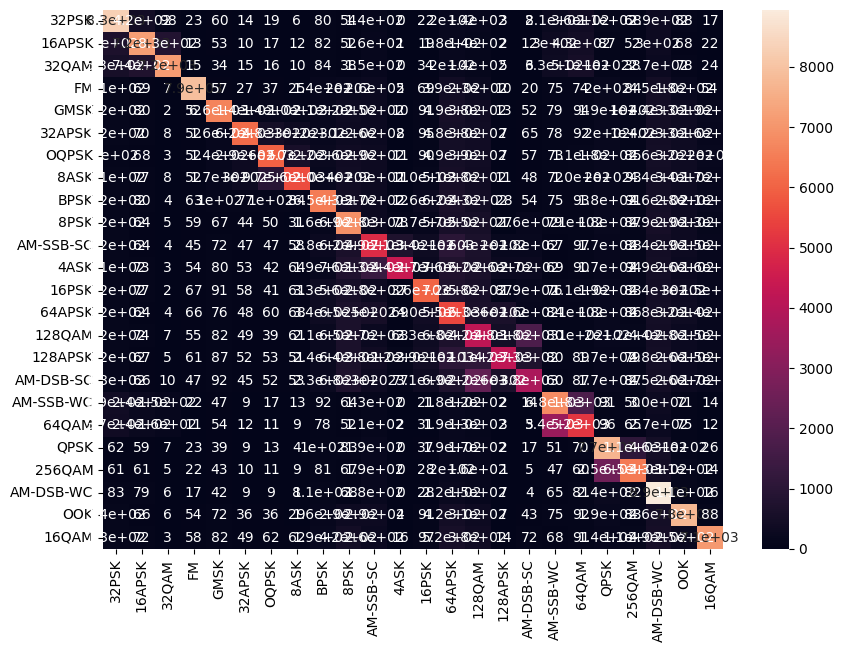

2023-08-11 22:43:22.102917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


998/998 [==============================] - 106s 105ms/step
Preds shape: (255488, 24)
Overall test accuracy: {'Overall': 0.5938791645791583}
32PSK test accuracy: 0.7761152928217367
16APSK test accuracy: 0.6682058047493403
32QAM test accuracy: 0.6833255488089678
FM test accuracy: 0.744257991937752
GMSK test accuracy: 0.6279420071549614
32APSK test accuracy: 0.5794055005093064
OQPSK test accuracy: 0.5736731174554512
8ASK test accuracy: 0.5344494526722473
BPSK test accuracy: 0.6121839723854837
8PSK test accuracy: 0.6510509944386841
AM-SSB-SC test accuracy: 0.4661008958038661
4ASK test accuracy: 0.4070068404511
16PSK test accuracy: 0.565016501650165
64APSK test accuracy: 0.5176128911373431
128QAM test accuracy: 0.4002276176024279
128APSK test accuracy: 0.4036627961861607
AM-DSB-SC test accuracy: 0.34856870229007636
AM-SSB-WC test accuracy: 0.6445885005636979
64QAM test accuracy: 0.48642597257206827
QPSK test accuracy: 0.7379381831888429
256QAM test accuracy: 0.6001520334473585
AM-DSB-WC tes

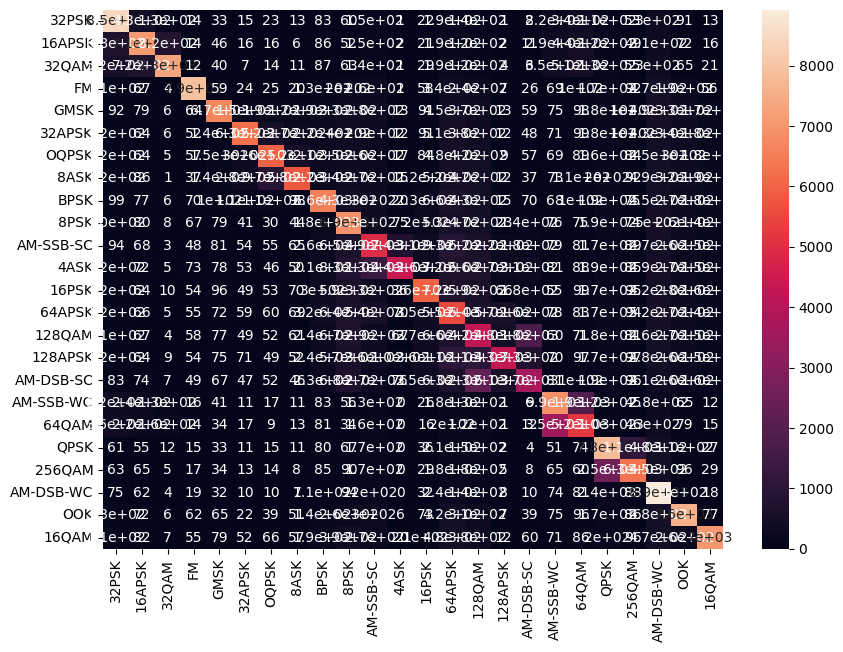

In [6]:
BATCH_SIZE = 256
test_generator = ds.to_keras_generator(split_indecies.test, batch_size=BATCH_SIZE, shuffle=False)
val_generator = ds.to_keras_generator(split_indecies.val, batch_size=BATCH_SIZE, shuffle=False)
# n_test_samples = len(split_indecies.test)
# n_val_samples = len(split_indecies.val)
test_steps = len(test_generator)
val_steps = len(val_generator)
# test_steps = 10
# val_steps = 10
actual_n_test_samples = test_steps * BATCH_SIZE
actual_n_val_samples = val_steps * BATCH_SIZE


def predict_gen(model, generator, *args, **kwargs):
    return model.predict(generator, steps=kwargs["steps"], workers=8)


cm_test, cls_to_acc_test = metric_evaluation(
    model,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_modulations(),
    predict_func=predict_gen,
    predict_kwargs={"steps": test_steps},
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    val_generator,
    ds.get_labels()[split_indecies.val][:actual_n_val_samples],
    ds.get_modulations(),
    predict_func=predict_gen,
    predict_kwargs={"steps": val_steps},
)

In [7]:
from sklearn.metrics import accuracy_score
from typing import Dict


def snr_to_metric_evaluation_generator(
    model,
    data_gen,
    labels: np.ndarray,
    snrs: np.ndarray,
    verbose=True,
    metric=accuracy_score,
    predict_args=None,
    predict_kwargs=None,
) -> Dict[float, float]:
    """
    Evaluates model on different snrs

    Returns:
        Dict[str]: Dict snr -> accuracy
    """
    predict_args = [] if predict_args is None else predict_args
    predict_kwargs = {"verbose": 0} if predict_kwargs is None else predict_kwargs

    snr_to_acc = {}
    pred = model.predict(data_gen, workers=8, *predict_args, **predict_kwargs)
    # for snr in range(min(snrs), max(snrs) + 2, 2):
    for snr in sorted(np.unique(snrs)):
        cur_indecies = np.where(snrs == snr)[0]
        cur_labels = labels[cur_indecies]
        cur_pred = pred[cur_indecies]

        cur_pred_labels = np.argmax(cur_pred, axis=1)
        acc = metric(cur_labels, cur_pred_labels)
        verbose and print(f"SNR: {snr} -- Overall test accuracy: {acc}")
        snr_to_acc[float(snr)] = float(acc)
    return snr_to_acc

In [8]:
test_steps = len(test_generator)
val_steps = len(val_generator)
# test_steps = 10
# val_steps = 10
actual_n_test_samples = test_steps * BATCH_SIZE
actual_n_val_samples = val_steps * BATCH_SIZE

snr_to_acc_test = snr_to_metric_evaluation_generator(
    model,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_snrs()[split_indecies.test][:actual_n_test_samples],
    True,
    predict_kwargs={"steps": test_steps}
)

snr_to_acc_val = snr_to_metric_evaluation_generator(
    model,
    val_generator,
    ds.get_labels()[split_indecies.val][:actual_n_val_samples],
    ds.get_snrs()[split_indecies.val][:actual_n_val_samples],
    True,
    predict_kwargs={"steps": val_steps}
)

2023-08-11 22:48:16.345334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


998/998 [==============================] - 85s 85ms/step
SNR: -20 -- Overall test accuracy: 0.044122152997650904
SNR: -18 -- Overall test accuracy: 0.04807885737276202
SNR: -16 -- Overall test accuracy: 0.052188893392784756
SNR: -14 -- Overall test accuracy: 0.06521739130434782
SNR: -12 -- Overall test accuracy: 0.09208484221417486
SNR: -10 -- Overall test accuracy: 0.145676500508647
SNR: -8 -- Overall test accuracy: 0.1989749773892071
SNR: -6 -- Overall test accuracy: 0.26815131177547286
SNR: -4 -- Overall test accuracy: 0.33968382650993106
SNR: -2 -- Overall test accuracy: 0.44003671221701
SNR: 0 -- Overall test accuracy: 0.534318687993521
SNR: 2 -- Overall test accuracy: 0.6340748230535895
SNR: 4 -- Overall test accuracy: 0.7335217522963561
SNR: 6 -- Overall test accuracy: 0.8347216578626575
SNR: 8 -- Overall test accuracy: 0.8801790547574433
SNR: 10 -- Overall test accuracy: 0.9039991838400326
SNR: 12 -- Overall test accuracy: 0.9200080192461909
SNR: 14 -- Overall test accuracy: 0.

2023-08-11 22:49:46.600694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


998/998 [==============================] - 83s 83ms/step
SNR: -20 -- Overall test accuracy: 0.041977800201816344
SNR: -18 -- Overall test accuracy: 0.04426045180415006
SNR: -16 -- Overall test accuracy: 0.04963963049436605
SNR: -14 -- Overall test accuracy: 0.0626421335538557
SNR: -12 -- Overall test accuracy: 0.09664167608092841
SNR: -10 -- Overall test accuracy: 0.14220647773279352
SNR: -8 -- Overall test accuracy: 0.19738722188201674
SNR: -6 -- Overall test accuracy: 0.2760385310054184
SNR: -4 -- Overall test accuracy: 0.3399918049580004
SNR: -2 -- Overall test accuracy: 0.4308868501529052
SNR: 0 -- Overall test accuracy: 0.544404701073071
SNR: 2 -- Overall test accuracy: 0.6348215214902695
SNR: 4 -- Overall test accuracy: 0.7353684423329627
SNR: 6 -- Overall test accuracy: 0.8317181506157885
SNR: 8 -- Overall test accuracy: 0.8849969629479651
SNR: 10 -- Overall test accuracy: 0.9083450070042025
SNR: 12 -- Overall test accuracy: 0.9156527118993607
SNR: 14 -- Overall test accuracy: 0

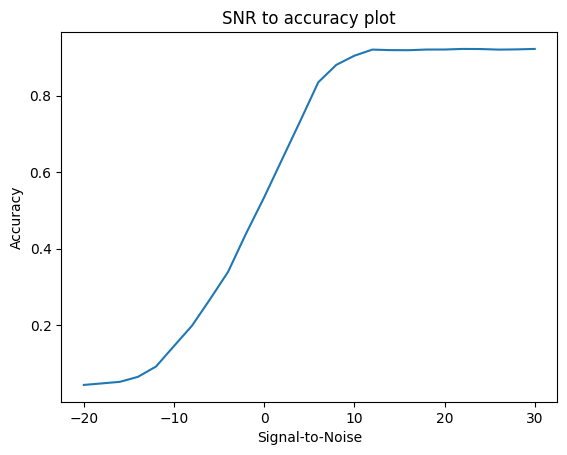

In [9]:
plot_snr_to_acc(snr_to_acc_test)

In [10]:
from evaluation.results_serialization import dump_results

from copy import deepcopy


if train_model:
    history = deepcopy(h.history)
    history["lr"] = list(map(lambda x: float(x), history["lr"]))

    dump_results(
        model_name + "_results/",
        model=model,
        model_config=model_configuration,
        model_name=ModelName.CNN_1D_V012,
        dataset_name=DatasetName.RADIOML_2016,
        dataset_path=radioml2018_data_path + " " + radioml2018_classes_path,
        train_history=history,
        cm_test=cm_test,
        cls_to_acc_test=cls_to_acc_test,
        snr_to_acc_test=snr_to_acc_test,
        cm_val=cm_val,
        cls_to_acc_val=cls_to_acc_val,
        snr_to_acc_val=snr_to_acc_val,
        short_description="Smaller + dense, 48 epochs with more decay (16:/=10, 24:/=4, 32: /=4)",
        dump_model=True,
    )

# TF lite quantization

In [6]:
# let's create representative dataset from generator
repr_ds_size = 4000

if not train_model:
    train_gen = ds.to_keras_generator(split_indecies.train, BATCH_SIZE)

n_samples = int(np.ceil(repr_ds_size / train_gen.batch_size))
print(n_samples)

repr_X = np.empty((n_samples * BATCH_SIZE, 1024, 2), dtype=np.float32)
repr_y = np.empty((n_samples * BATCH_SIZE,), dtype=np.uint8)
for i in range(n_samples):
    repr_X[i * BATCH_SIZE : (i + 1) * BATCH_SIZE], repr_y[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = train_gen[i]

16


In [8]:
# reload_module("deployment_tools")
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from tqdm import trange

model_path = f"{model_name}_results/model_original"
model.save(model_path)

model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=repr_X)


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml18_results/model_original/assets


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml18_results/model_original/assets
2023-08-13 13:37:35.973844: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-13 13:37:35.973873: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-13 13:37:35.974520: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml18_results/model_original
2023-08-13 13:37:35.976318: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-13 13:37:35.976330: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml18_results/model_original
2023-08-13 13:37:35.980789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-08-13 13:37:35.981761: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedM

In [9]:
X0, y0 = test_generator[0]
print(X0.shape)
print(y0.shape) 

y0_pred = np.argmax(predict_tflite(model_tflile, X0), axis=1)
y0_pred2 = np.argmax(model.predict(X0), axis=1)
print(y0)
print(y0_pred)
print(y0_pred2)

NameError: name 'test_generator' is not defined

100%|██████████| 998/998 [03:17<00:00,  5.06it/s]


Preds shape: (255488, 24)
Overall test accuracy: {'Overall': 0.5921452279559118}
32PSK test accuracy: 0.782519567648155
16APSK test accuracy: 0.6681881695388915
32QAM test accuracy: 0.6793617627504986
FM test accuracy: 0.7483183856502242
GMSK test accuracy: 0.6863117870722434
32APSK test accuracy: 0.5909865555765953
OQPSK test accuracy: 0.5682356283738991
8ASK test accuracy: 0.5223852696513693
BPSK test accuracy: 0.6071596796985398
8PSK test accuracy: 0.6484133670317327
AM-SSB-SC test accuracy: 0.4548184292014638
4ASK test accuracy: 0.4126806526806527
16PSK test accuracy: 0.5657709952251662
64APSK test accuracy: 0.49368381943154377
128QAM test accuracy: 0.38243089738735325
128APSK test accuracy: 0.39486552567237165
AM-DSB-SC test accuracy: 0.348975791433892
AM-SSB-WC test accuracy: 0.6428705793829947
64QAM test accuracy: 0.47719992462785
QPSK test accuracy: 0.7410415671285236
256QAM test accuracy: 0.6004344130701672
AM-DSB-WC test accuracy: 0.8399962106858658
OOK test accuracy: 0.70381

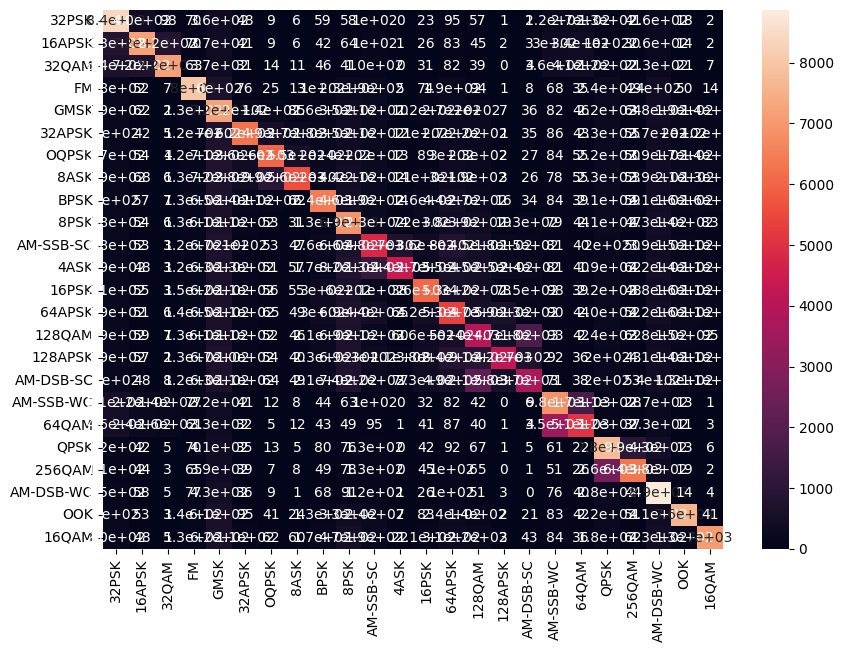

In [33]:
def predict_tflite_gen(model, generator, *args, **kwargs):
    bs = generator.batch_size
    pred = np.empty((len(generator) * bs, generator.n_classes), dtype=np.float32)
    for i in trange(len(generator)):
        pred[i*bs:(i+1)*bs] = predict_tflite(model, generator[i][0])
    return pred


cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_modulations(),
    predict_func=predict_tflite_gen,
    predict_kwargs={"steps": test_steps},
)


In [35]:
# TODO: reuse previous function, add predict_func argument
def snr_to_metric_evaluation_generator_tflite(
    model,
    data_gen,
    labels: np.ndarray,
    snrs: np.ndarray,
    verbose=True,
    metric=accuracy_score,
    predict_args=None,
    predict_kwargs=None,
) -> Dict[float, float]:
    """
    Evaluates model on different snrs

    Returns:
        Dict[str]: Dict snr -> accuracy
    """
    predict_args = [] if predict_args is None else predict_args
    predict_kwargs = {"verbose": 0} if predict_kwargs is None else predict_kwargs

    snr_to_acc = {}
    # pred = model.predict(data_gen, workers=8, *predict_args, **predict_kwargs)
    pred = predict_tflite_gen(model, data_gen, *predict_args, **predict_kwargs)
    # for snr in range(min(snrs), max(snrs) + 2, 2):
    for snr in sorted(np.unique(snrs)):
        cur_indecies = np.where(snrs == snr)[0]
        cur_labels = labels[cur_indecies]
        cur_pred = pred[cur_indecies]

        cur_pred_labels = np.argmax(cur_pred, axis=1)
        acc = metric(cur_labels, cur_pred_labels)
        verbose and print(f"SNR: {snr} -- Overall test accuracy: {acc}")
        snr_to_acc[float(snr)] = float(acc)
    return snr_to_acc

100%|██████████| 998/998 [03:07<00:00,  5.33it/s]


SNR: -20 -- Overall test accuracy: 0.04238586456950261
SNR: -18 -- Overall test accuracy: 0.04395493864413599
SNR: -16 -- Overall test accuracy: 0.050060802594244024
SNR: -14 -- Overall test accuracy: 0.06663957740755791
SNR: -12 -- Overall test accuracy: 0.09280910501810657
SNR: -10 -- Overall test accuracy: 0.14435401831129197
SNR: -8 -- Overall test accuracy: 0.19967842427896693
SNR: -6 -- Overall test accuracy: 0.2677445596908684
SNR: -4 -- Overall test accuracy: 0.33978516416700444
SNR: -2 -- Overall test accuracy: 0.44024066897817665
SNR: 0 -- Overall test accuracy: 0.533508807450901
SNR: 2 -- Overall test accuracy: 0.6348837209302326
SNR: 4 -- Overall test accuracy: 0.7335217522963561
SNR: 6 -- Overall test accuracy: 0.834315318976026
SNR: 8 -- Overall test accuracy: 0.8803872579637726
SNR: 10 -- Overall test accuracy: 0.9039991838400326
SNR: 12 -- Overall test accuracy: 0.920308740978348
SNR: 14 -- Overall test accuracy: 0.9186354378818737
SNR: 16 -- Overall test accuracy: 0.91

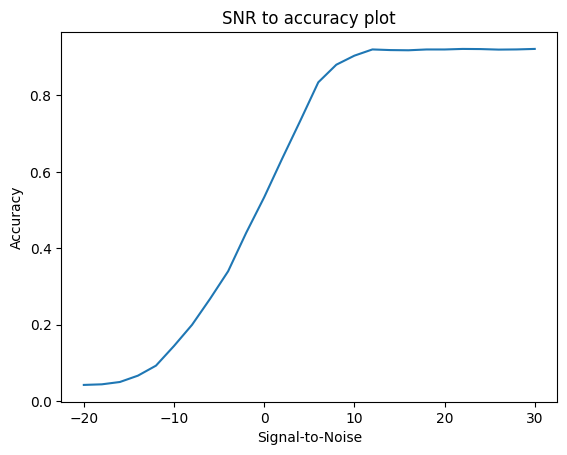

In [36]:
snr_to_acc_test_tflite = snr_to_metric_evaluation_generator_tflite(
    model_tflile,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_snrs()[split_indecies.test][:actual_n_test_samples],
    True,
)

plot_snr_to_acc(snr_to_acc_test_tflite)

In [44]:
interpreter = tf.lite.Interpreter(model_content=model_tflile)
print(interpreter.get_input_details())
print(interpreter.get_output_details()[0])

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([   1, 1024,    2], dtype=int32), 'shape_signature': array([  -1, 1024,    2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
{'name': 'StatefulPartitionedCall:0', 'index': 56, 'shape': array([ 1, 24], dtype=int32), 'shape_signature': array([-1, 24], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [10]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=repr_X,
    test_labels=repr_y,
    model_name=model_name,
    classes=ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[debug] Export test data


24it [00:00, 648.22it/s]


RuntimeError: project directory already exists